## Setup

In [ ]:
import os
import shutil
from datetime import datetime
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# gradcam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [9]:
def list_files(path):
    return [os.path.join(path, label, filename) for label in os.listdir(path) for filename in os.listdir(os.path.join(path, label))]

def move_files(files, target_path):
    os.makedirs(target_path, exist_ok=True)

    for filepath in files:
        target_filepath = os.path.join(target_path, filepath.split("/")[-2])
        os.makedirs(target_filepath, exist_ok=True)
        shutil.copy(filepath, target_filepath)

    print(f"[INFO] Moved {len(files)} files to {target_path}")

## Get data

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p ../data
!unzip -o ../data/brain-tumor-mri-dataset.zip -d ../data/brain_tumor_mri_dataset

In [14]:
train_path = "../data/brain_tumor_mri_dataset/Training"
validtest_path = "../data/brain_tumor_mri_dataset/Testing"
train_files = list_files(train_path)
validtest_files = list_files(validtest_path)
len(train_files), len(validtest_files)

(5712, 1311)

In [15]:
valid_files, test_files = train_test_split(
    validtest_files,
    test_size=0.5,
    random_state=42,
    stratify=[filename.split("/")[-2] for filename in validtest_files]
)

In [16]:
train_path = "../data/brain_tumor_mri_dataset/train"
move_files(train_files, train_path)

valid_path = "../data/brain_tumor_mri_dataset/validation"
move_files(valid_files, valid_path)

test_path = "../data/brain_tumor_mri_dataset/test"
move_files(test_files, test_path)

[INFO] Moved 5712 files to ../data/brain_tumor_mri_dataset/train
[INFO] Moved 655 files to ../data/brain_tumor_mri_dataset/validation
[INFO] Moved 656 files to ../data/brain_tumor_mri_dataset/test


## Define datasets

In [17]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, label, filename) for label in os.listdir(root_dir) for filename in os.listdir(os.path.join(root_dir, label))]
        labels = sorted(os.listdir(root_dir))
        self.label2idx = {label: idx for idx, label in enumerate(labels)}
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        filename = self.image_files[idx]
        image = Image.open(filename).convert('RGB')
        label = self.label2idx[filename.split("/")[-2]]
        if self.transform:
            image_tensor = self.transform(image)
        return image_tensor, label

In [18]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [19]:
train_path = "../data/brain_tumor_mri_dataset/train"

valid_path = "../data/brain_tumor_mri_dataset/validation"

test_path = "../data/brain_tumor_mri_dataset/test"

train_ds = BrainTumorDataset(train_path, transform=preprocess)
valid_ds = BrainTumorDataset(valid_path, transform=preprocess)
test_ds = BrainTumorDataset(test_path, transform=preprocess)

print(f"Train dataset: {len(train_ds)}")
print(f"Validation dataset: {len(valid_ds)}")
print(f"Test dataset: {len(test_ds)}")


Train dataset: 5712
Validation dataset: 655
Test dataset: 656


In [20]:
train_ds[0][0].shape

torch.Size([3, 224, 224])

## Define dataloaders

In [21]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [22]:
batch = next(iter(train_dl))
batch[0].shape, batch[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Training

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [132]:
torch.manual_seed(42)
model = efficientnet_b0(weights=weights)

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(1280, 4)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
timestamp  = datetime.now().strftime("%Y%m%d_%H%M%S")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_targets_all = []
    train_preds_all = []

    # train step
    for batch in train_dl:
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=-1)
        
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_targets_all.extend(y.cpu().numpy())
        train_preds_all.extend(preds.cpu().numpy())

    train_loss /= len(train_dl)
    train_acc = accuracy_score(train_targets_all, train_preds_all)

    # eval step
    model.eval()
    with torch.inference_mode():
        eval_loss = 0
        eval_targets_all = []
        eval_preds_all = []

        for batch in valid_dl:
            x, y = batch[0].to(device), batch[1].to(device)
            y_pred = model(x)
            preds = torch.argmax(y_pred, dim=-1)

            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            eval_targets_all.extend(y.cpu().numpy())
            eval_preds_all.extend(preds.cpu().numpy())

        eval_loss /= len(valid_dl)
        valid_acc = accuracy_score(eval_targets_all, eval_preds_all)


    print(f"[INFO] Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2%} | Validation Loss: {eval_loss:.4f} | Validation Accuracy: {valid_acc:.2%}")

checkpoint_filename = f"../models/efficientnet_b0_{timestamp}.pth"
torch.save(model.state_dict(), checkpoint_filename)

[INFO] Train Loss: 0.4517 | Train Accuracy: 84.37% | Validation Loss: 0.4064 | Validation Accuracy: 85.50%
[INFO] Train Loss: 0.3147 | Train Accuracy: 88.50% | Validation Loss: 0.3252 | Validation Accuracy: 87.79%
[INFO] Train Loss: 0.2935 | Train Accuracy: 89.20% | Validation Loss: 0.3123 | Validation Accuracy: 88.40%
[INFO] Train Loss: 0.2661 | Train Accuracy: 90.39% | Validation Loss: 0.2880 | Validation Accuracy: 89.92%
[INFO] Train Loss: 0.2510 | Train Accuracy: 90.88% | Validation Loss: 0.2821 | Validation Accuracy: 89.62%
[INFO] Train Loss: 0.2465 | Train Accuracy: 90.74% | Validation Loss: 0.2786 | Validation Accuracy: 89.47%
[INFO] Train Loss: 0.2637 | Train Accuracy: 90.62% | Validation Loss: 0.2455 | Validation Accuracy: 90.38%
[INFO] Train Loss: 0.2372 | Train Accuracy: 91.04% | Validation Loss: 0.2893 | Validation Accuracy: 88.40%
[INFO] Train Loss: 0.2252 | Train Accuracy: 92.33% | Validation Loss: 0.2438 | Validation Accuracy: 90.69%
[INFO] Train Loss: 0.2300 | Train Acc

## Evaluation

In [133]:
# eval step
model.eval()
with torch.inference_mode():
    eval_loss = 0
    eval_targets_all = []
    eval_preds_all = []

    for batch in test_dl:
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=-1)

        loss = loss_fn(y_pred, y)
        eval_loss += loss.item()
        eval_targets_all.extend(y.cpu().numpy())
        eval_preds_all.extend(preds.cpu().numpy())

    eval_loss /= len(valid_dl)
    valid_acc = accuracy_score(eval_targets_all, eval_preds_all)

print(f"[INFO] Test Loss: {eval_loss:.4f} | Test Accuracy: {valid_acc:.2%}")

[INFO] Test Loss: 0.1618 | Test Accuracy: 93.90%


## Load checkpoint

In [134]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [136]:
def load_checkpoint(checkpoint_filename):
    model = efficientnet_b0()
    model.classifier[1] = nn.Linear(1280, 4)
    print(f"[INFO] Loading checkpoint from {checkpoint_filename}...")
    model.load_state_dict(torch.load(checkpoint_filename))
    model = model.to(device)

    return model

model_loaded = load_checkpoint("../models/efficientnet_b0_20241116_121021.pth")

[INFO] Loading checkpoint from ../models/efficientnet_b0_20241116_121021.pth...


/var/folders/pb/7g765q5n1ws4ltc9cdtw4bq40000gn/T/ipykernel_88733/3112033753.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_f

In [137]:
loss_fn = nn.CrossEntropyLoss()

# eval step
model_loaded.eval()
with torch.inference_mode():
    eval_loss = 0
    eval_targets_all = []
    eval_preds_all = []

    for batch in test_dl:
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred = model_loaded(x)
        preds = torch.argmax(y_pred, dim=-1)

        loss = loss_fn(y_pred, y)
        eval_loss += loss.item()
        eval_targets_all.extend(y.cpu().numpy())
        eval_preds_all.extend(preds.cpu().numpy())

    eval_loss /= len(valid_dl)
    valid_acc = accuracy_score(eval_targets_all, eval_preds_all)

print(f"[INFO] Test Loss: {eval_loss:.4f} | Test Accuracy: {valid_acc:.2%}")

[INFO] Test Loss: 0.1618 | Test Accuracy: 93.90%


## Inference

In [138]:
idx2label = {v: k for k, v in train_ds.label2idx.items()}
labels = list(idx2label.values())
print(f"Labels: {labels}")

def preprocess_image(image):
    image_tensor = preprocess(image)
    return image_tensor.to(device).unsqueeze(0)

Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [149]:
test_filepath = "../data/brain_tumor_mri_dataset/test/pituitary/Te-pi_0256.jpg"
image_test = Image.open(test_filepath).convert("RGB")
target_label = test_filepath.split("/")[-2]

image_tensor = preprocess_image(image_test)
print(image_tensor.shape)

torch.Size([1, 3, 224, 224])


In [150]:
def make_prediction(model, image_tensor):
    model.eval()
    with torch.inference_mode():
        logits = model(image_tensor)
        probs = torch.softmax(logits, dim=-1).detach().cpu().squeeze().numpy()
        pred_idx = torch.argmax(logits, dim=-1).item()
        pred_label = labels[pred_idx]

    return pred_label, probs


pred_label, probs = make_prediction(model_loaded, image_tensor)
print(f"Predicted label: {pred_label}")
print(f"Probabilities: {probs}")

Predicted label: pituitary
Probabilities: [5.0340570e-04 1.1077276e-02 1.7640397e-05 9.8840171e-01]


## GramCAM

In [151]:
def compute_gradcam(model, input_image, input_tensor, pred_label):
    image_resized = input_image.resize((224, 224))
    image_np = np.array(image_resized).astype(np.float32) / 255.0

    target_layers = [model.features[-1][2]]
    targets = [ClassifierOutputTarget(labels.index(pred_label))]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        # You can also get the model outputs without having to redo inference
        model_outputs = cam.outputs
    
    gradcam_image = Image.fromarray(visualization)

    return image_resized, gradcam_image

In [152]:
image_resized, gradcam_image = compute_gradcam(model_loaded, image_test, image_tensor, pred_label)

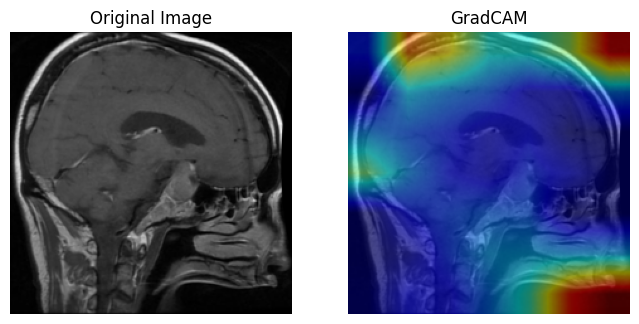

In [153]:
def display_gradcam(image, gradcam_image):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image)
    ax[0].axis("off")
    ax[0].set_title("Original Image")
    ax[1].imshow(gradcam_image)
    ax[1].axis("off")
    ax[1].set_title("GradCAM")
    plt.show()

display_gradcam(image_resized, gradcam_image)